In [ ]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

In [ ]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

In [ ]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, 
# you need to use the persistence path as the following: 
!mkdir /home/aistudio/external-libraries
!pip install beautifulsoup4 -t /home/aistudio/external-libraries

In [ ]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')

In [1]:
!pip install d2l

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.6/112.6 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 3.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 2.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 2.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 2.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.24.0
    Uninstalling requests-2.24.0:
      Successfully uninstalled requests-2.24.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling num

In [1]:
import warnings
from d2l import paddle as d2l
warnings.filterwarnings("ignore")
import paddle
import paddle.nn as nn
import paddle.nn.functional as F

In [2]:
class Inception(nn.Layer):
    def __init__(self, in_channels, c1,c2,c3,c4,**kwargs):
        super(Inception,self).__init__(**kwargs)
        # 线路1，单1*1卷积层
        self.p1_1=nn.Conv2D(in_channels,c1,kernel_size=1)
        # 线路2，1*1卷积层后接3*3卷积
        self.p2_1=nn.Conv2D(in_channels,c2[0],kernel_size=1)
        self.p2_2=nn.Conv2D(c2[0],c2[1],kernel_size=3,padding=1)
        # 线路3，1*1卷积层后5*5卷积层
        self.p3_1=nn.Conv2D(in_channels,c3[0],kernel_size=1)
        self.p3_2=nn.Conv2D(c3[0],c3[1],kernel_size=5,padding=2)
        # 线路4，3*3最大池化层后接1*1卷积层
        self.p4_1=nn.MaxPool2D(kernel_size=3,stride=1,padding=1)
        self.p4_2=nn.Conv2D(in_channels,c4,kernel_size=1)
    def forward(self, x):
        p1=F.relu(self.p1_1(x))
        p2=F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3=F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4=F.relu(self.p4_2(F.relu(self.p4_1(x))))
        # 在通道维度上连结输出
        return paddle.concat(x=[p1,p2,p3,p4],axis=1)

## [**GoogLeNet模型**]

如 :numref:`fig_inception_full`所示，GoogLeNet一共使用9个Inception块和全局平均汇聚层的堆叠来生成其估计值。Inception块之间的最大汇聚层可降低维度。
第一个模块类似于AlexNet和LeNet，Inception块的组合从VGG继承，全局平均汇聚层避免了在最后使用全连接层。

![GoogLeNet架构。](../img/inception-full.svg)
:label:`fig_inception_full`

现在，我们逐一实现GoogLeNet的每个模块。第一个模块使用64个通道、$7\times 7$卷积层。


In [3]:
b1=nn.Sequential(nn.Conv2D(1,64,kernel_size=7,stride=2,padding=3),nn.ReLU(),nn.MaxPool2D(kernel_size=3,stride=2,padding=1))

W0206 11:47:04.606853  2383 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 11.2
W0206 11:47:04.611496  2383 gpu_resources.cc:91] device: 0, cuDNN Version: 8.2.


In [4]:
!nvidia-smi

Mon Feb  6 11:47:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:05:00.0 Off |                    0 |
| N/A   39C    P0    59W / 300W |    737MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
b2=nn.Sequential(nn.Conv2D(64,64,kernel_size=1),nn.ReLU(),nn.Conv2D(64,192,kernel_size=3,padding=1),nn.ReLU(),nn.MaxPool2D(kernel_size=3,stride=2,padding=1))

In [6]:
b3=nn.Sequential(Inception(192,64,(96,128),(16,32),32),Inception(256,128,(128,192),(32,96),64),
nn.MaxPool2D(kernel_size=3,stride=2,padding=1))

In [7]:
b4=nn.Sequential(Inception(480,192,(96,208),(16,48),64),
Inception(512, 160, (112, 224), (24, 64), 64),
Inception(512, 128, (128, 256), (24, 64), 64),
Inception(512, 112, (144, 288), (32, 64), 64),
Inception(528, 256, (160, 320), (32, 128), 128),
nn.MaxPool2D(kernel_size=3,stride=2,padding=1))

In [8]:
b5=nn.Sequential(
    Inception(832, 256, (160, 320), (32, 128), 128),
    Inception(832, 384, (192, 384), (48, 128), 128),
    nn.AdaptiveAvgPool2D((1,1)),
    nn.Flatten()
)
net=nn.Sequential(b1,b2,b3,b4,b5,nn.Linear(1024,10))

In [9]:
X=paddle.rand(shape=(1,1,96,96))
for layer in net:
    X=layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 [1, 64, 24, 24]
Sequential output shape:	 [1, 192, 12, 12]
Sequential output shape:	 [1, 480, 6, 6]
Sequential output shape:	 [1, 832, 3, 3]
Sequential output shape:	 [1, 1024]
Linear output shape:	 [1, 10]


loss 0.250, train acc 0.906, test acc 0.899
2397.0 examples/sec on Place(gpu:0)


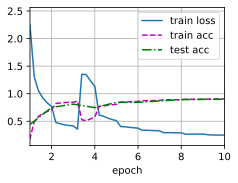

In [10]:
lr,num_epochs,batch_size=0.1,10,128
train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size,resize=96)
d2l.train_ch6(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 